In [ ]:
!pip install emoji
!pip install beautifulsoup4
import os
import re
import string
import json
import emoji
import numpy as np
import pandas as pd
from sklearn import metrics
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, accuracy_score, f1_score
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [ ]:

df1 = pd.read_csv('27goemotions_no_multi_label_1.csv')
df2 = pd.read_csv('27goemotions_no_multi_label_2.csv')
df3 = pd.read_csv('27goemotions_no_multi_label_3.csv')
df = pd.concat([df1, df2, df3], ignore_index=True)

df.head()


,text,id,author,subreddit,link_id,parent_id,created_utc,rater_id,example_very_unclear,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,disapproval,disgust,embarrassment,excitement,fear,gratitude,grief,joy,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
0,That game hurt.,eew5j0j,Brdd9,nrl,t3_ajis4z,t1_eew18eq,1.548381e+09,1,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,>sexuality shouldn’t be a grouping category I...,eemcysk,TheGreen888,unpopularopinion,t3_ai4q37,t3_ai4q37,1.548084e+09,37,True,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,"You do right, if you don't care then fuck 'em!",ed2mah1,Labalool,confessions,t3_abru74,t1_ed2m7g7,1.546428e+09,37,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,Man I love reddit.,eeibobj,MrsRobertshaw,facepalm,t3_ahulml,t3_ahulml,1.547965e+09,18,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,"[NAME] was nowhere near them, he was by the Fa...",eda6yn6,American_Fascist713,starwarsspeculation,t3_ackt2f,t1_eda65q2,1.546669e+09,2,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Memilih kolom yang diinginkan
columns_to_keep = ['text', 'caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
df = df[columns_to_keep]

# Menghapus baris yang semua nilainya 0 untuk kategori yang diinginkan
df = df[
    (df['caring'] != 0) |
    (df['love'] != 0) |
    (df['gratitude'] != 0) |
    (df['sadness'] != 0) |
    (df['fear'] != 0) |
    (df['anger'] != 0)
]

df.head()

,text,caring,love,gratitude,sadness,fear,anger
0,That game hurt.,0,0,0,1,0,0
3,Man I love reddit.,0,1,0,0,0,0
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0
14,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0
25,"Yup, not anymore. Keep your blood sugar up! It...",1,0,0,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28011 entries, 0 to 180600
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       28011 non-null  object
 1   caring     28011 non-null  int64 
 2   love       28011 non-null  int64 
 3   gratitude  28011 non-null  int64 
 4   sadness    28011 non-null  int64 
 5   fear       28011 non-null  int64 
 6   anger      28011 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 1.7+ MB


In [ ]:
df.duplicated().sum()

9426

In [ ]:
df['text'].duplicated().sum()

10702

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df['sum']= df.iloc[:, 1:].sum(axis=1)
df.head(10)

,text,caring,love,gratitude,sadness,fear,anger,sum
0,That game hurt.,0,0,0,1,0,0,1
3,Man I love reddit.,0,1,0,0,0,0,1
5,Right? Considering it’s such an important docu...,0,0,1,0,0,0,1
14,"I appreciate it, that's good to know. I hope I...",0,0,1,0,0,0,1
25,"Yup, not anymore. Keep your blood sugar up! It...",1,0,0,0,0,0,1
30,I’m glad he’s okay but I’m even gladder it’s n...,0,0,1,0,0,0,1
33,"I just came home, what the fuck is this lineup...",0,1,0,0,0,0,1
45,Thanks for the info mate gonna watch out next ...,0,0,1,0,0,0,1
51,Gotta protect’em!,1,0,0,0,0,0,1
56,"Thanks, it was no effort at all.",0,0,1,0,0,0,1


In [ ]:
df['sum'].value_counts()

,count
sum,
1,17309


In [ ]:
df = df.drop('sum', axis=1)

In [ ]:
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']
emotion_counts = (df[emotions].sum())
emotion_counts

,0
caring,2551
love,3053
gratitude,4028
sadness,2703
fear,1179
anger,3795


## Balancing Data

In [ ]:
from sklearn.utils import resample
def balance_per_category(df, label_columns):
    balanced_data = []
    min_samples = df[label_columns].sum(axis=0).min()  # Ambil jumlah minimum label sebagai target

    for label in label_columns:
        category_data = df[df[label] == 1]  # Ambil data yang sesuai dengan label
        balanced_data.append(resample(category_data, n_samples=min_samples, random_state=42))

    return pd.concat(balanced_data).sample(frac=1, random_state=42)

In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       1179
love         1179
gratitude    1179
sadness      1179
fear         1179
anger        1179
dtype: int64


In [ ]:
df['text'].duplicated().sum()

1450

In [ ]:
df = df.drop_duplicates(subset ='text')

In [ ]:
df['text'].duplicated().sum()

0

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5624 entries, 18132 to 155530
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       5624 non-null   object
 1   caring     5624 non-null   int64 
 2   love       5624 non-null   int64 
 3   gratitude  5624 non-null   int64 
 4   sadness    5624 non-null   int64 
 5   fear       5624 non-null   int64 
 6   anger      5624 non-null   int64 
dtypes: int64(6), object(1)
memory usage: 351.5+ KB


In [ ]:
df = balance_per_category(df, emotions)
print(df[emotions].sum())

caring       745
love         745
gratitude    745
sadness      745
fear         745
anger        745
dtype: int64


In [ ]:
# Daftar emosi
from sklearn.model_selection import train_test_split
emotions = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

# Misalkan dataset adalah DataFrame dengan fitur `X` dan label `y`
X = df['text']  # Fitur teks
y = df[emotions].copy()  # Label emosi

# Langkah 1: Pisahkan data training (80%) dan sisanya (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Langkah 2: Pisahkan data testing dan validasi dari sisanya (masing-masing 50% dari 20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Menghitung class weights untuk data training
class_counts = y_train.sum(axis=0)
total_count = class_counts.sum()
class_weights = (1 / class_counts) * (total_count / len(class_counts))

In [ ]:
# Konversi ke dictionary untuk TensorFlow
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

In [ ]:
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Testing set:", X_test.shape, y_test.shape)


Training set: (3576,) (3576, 6)
Validation set: (447,) (447, 6)
Testing set: (447,) (447, 6)


In [ ]:
# Menampilkan class weights
pd.DataFrame([class_weights.round(2)], columns=y.columns, index=['Weight'])

,caring,love,gratitude,sadness,fear,anger
Weight,1.0,0.99,0.98,1.03,0.99,1.01


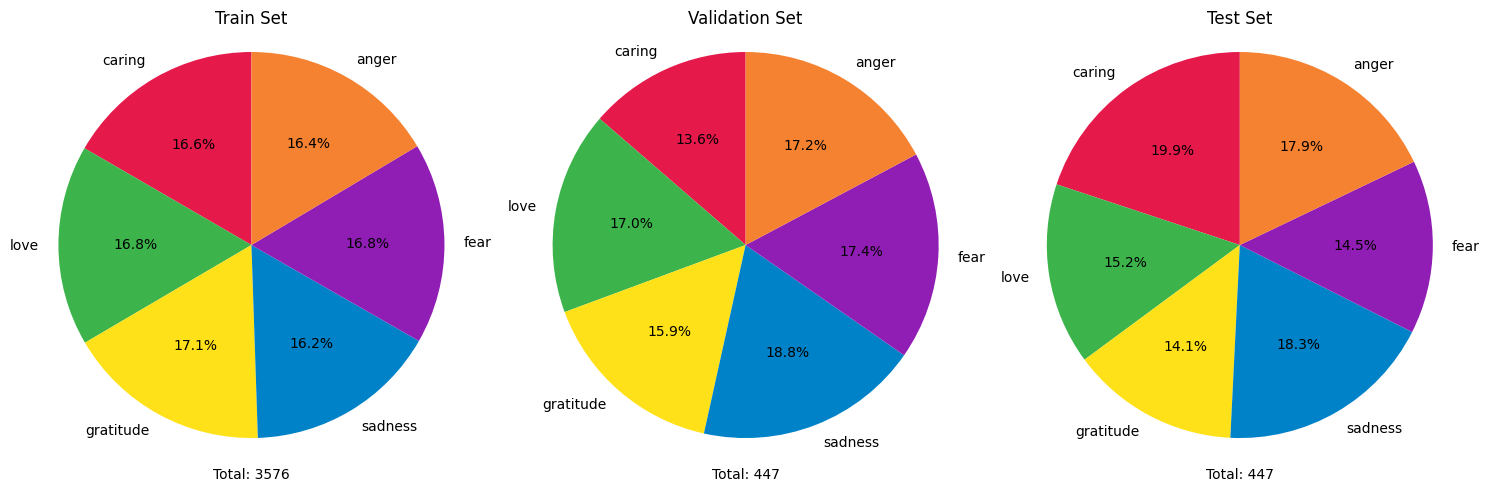

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Define a color map for each label
colors = {
    'caring': '#e6194b',
    'love': '#3cb44b',
    'gratitude': '#ffe119',
    'sadness': '#0082c8',
    'fear': '#911eb4',
    'anger': '#f58231',

}

# Function to compute label counts for multi-label data
def compute_label_counts(ds):
    return ds.sum(axis=0)

# Get the counts of each label in each set
train_counts = compute_label_counts(y_train)
val_counts = compute_label_counts(y_val)
test_counts = compute_label_counts(y_test)

# Generate the pie charts
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

datasets = [
    (train_counts, "Train Set"),
    (val_counts, "Validation Set"),
    (test_counts, "Test Set")
]

for i, (counts, title) in enumerate(datasets):
    labels = counts.index
    sizes = counts.values
    colors_list = [colors[label] for label in labels]
    axs[i].pie(sizes, labels=labels, colors=colors_list, autopct='%1.1f%%', startangle=90)
    axs[i].axis('equal')
    axs[i].set_title(title)
    axs[i].text(0.5, -0.05, f'Total: {int(sum(sizes))}', size=10, ha='center', transform=axs[i].transAxes)

plt.tight_layout()
plt.show()

In [ ]:
# Gabungkan kembali X dan y menjadi DataFrame untuk train, validation, dan test
df_train = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
df_val = pd.concat([X_val, y_val], axis=1).reset_index(drop=True)
df_test = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Cleaning Data

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                       "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                       "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                       "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am",
                       "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am",
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
                       "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not",
                       "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not",
                       "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not",
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will",
                       "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
                       "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is",
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would",
                       "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have",
                       "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have",
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have",
                       "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did",
                       "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is",
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                       "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would",
                       "y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have",
                       "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", 'u.s':'america', 'e.g':'for example'}

punct = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
 '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
 '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]

punct_mapping = {"‘": "'", "₹": "e", "´": "'", "°": "", "€": "e", "™": "tm", "√": " sqrt ", "×": "x", "²": "2", "—": "-", "–": "-", "’": "'", "_": "-",
                 "`": "'", '“': '"', '”': '"', '“': '"', "£": "e", '∞': 'infinity', 'θ': 'theta', '÷': '/', 'α': 'alpha', '•': '.', 'à': 'a', '−': '-',
                 'β': 'beta', '∅': '', '³': '3', 'π': 'pi', '!':' '}

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ',
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can',
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does',
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum',
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization'}

In [ ]:
def clean_text(text):
    '''Clean emoji, Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = emoji.demojize(text)
    text = re.sub(r'\:(.*?)\:','',text)
    text = str(text).lower()    #Making Text Lowercase
    text = re.sub('\[.*?\]', '', text)
    #The next 2 lines remove html text
    text = BeautifulSoup(text, 'lxml').get_text()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",", "'")
    text = re.sub(r"[^a-zA-Z?.!,¿']+", " ", text)
    return text

def clean_contractions(text, mapping):
    '''Clean contraction using contraction mapping'''
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    for word in mapping.keys():
        if ""+word+"" in text:
            text = text.replace(""+word+"", ""+mapping[word]+"")
    #Remove Punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    text = re.sub(r"([?.!,¿])", r" \1 ", text)
    text = re.sub(r'[" "]+', " ", text)
    return text

def clean_special_chars(text, punct, mapping):
    '''Cleans special characters present(if any)'''
    for p in mapping:
        text = text.replace(p, mapping[p])

    for p in punct:
        text = text.replace(p, f' {p} ')

    specials = {'\u200b': ' ', '…': ' ... ', '\ufeff': '', 'करना': '', 'है': ''}
    for s in specials:
        text = text.replace(s, specials[s])

    return text

def correct_spelling(x, dic):
    '''Corrects common spelling errors'''
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x

def remove_space(text):
    '''Removes awkward spaces'''
    #Removes awkward spaces
    text = text.strip()
    text = text.split()
    return " ".join(text)

def text_preprocessing_pipeline(text):
    '''Cleaning and parsing the text.'''
    text = clean_text(text)
    text = clean_contractions(text, contraction_mapping)
    text = clean_special_chars(text, punct, punct_mapping)
    text = correct_spelling(text, mispell_dict)
    text = remove_space(text)
    return text

In [ ]:
df_train['text'] = df_train['text'].apply(text_preprocessing_pipeline)
df_val['text'] = df_val['text'].apply(text_preprocessing_pipeline)

In [ ]:
df_train.head()

,text,caring,love,gratitude,sadness,fear,anger
0,i know maybe if they realize this they will st...,0,0,0,0,1,0
1,and should go sell his wifes ketchup he is goo...,0,0,0,0,0,1
2,wow excellent shot,0,0,1,0,0,0
3,that makes me feel even pettier thanks,0,0,1,0,0,0
4,my mom and i do the same exact thing i hate it,0,0,0,1,0,0


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(df_train['text'])
X_val_vec = vectorizer.transform(df_val['text'])
X_test_vec = vectorizer.transform(df_test['text'])

In [ ]:
# Definisikan parameter grid untuk hyperparameter tuning
param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': [0.1, 1, 10]
}


In [ ]:
# Melatih model SVM dengan One-vs-Rest menggunakan GridSearchCV
svm = SVC(probability=True)
classifier = OneVsRestClassifier(svm)
grid_search = GridSearchCV(classifier, param_grid, scoring='accuracy', cv=3, n_jobs=-1)


In [ ]:
# Melatih model menggunakan data training
grid_search.fit(X_train_vec, df_train[emotions])

GridSearchCV(cv=3,
             estimator=OneVsRestClassifier(estimator=SVC(probability=True)),
             n_jobs=-1,
             param_grid={'estimator__C': [0.1, 1, 10],
                         'estimator__gamma': [0.1, 1, 10],
                         'estimator__kernel': ['linear', 'rbf']},
             scoring='accuracy')

In [ ]:
# Hasil terbaik dari grid search
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters found: {'estimator__C': 10, 'estimator__gamma': 0.1, 'estimator__kernel': 'linear'}
Best cross-validation score: 0.6403803131991052


In [ ]:
# Gunakan model terbaik untuk prediksi
best_classifier = grid_search.best_estimator_

In [ ]:
# Evaluasi model pada set validasi
y_val_pred = best_classifier.predict(X_val_vec)
val_accuracy = accuracy_score(df_val[emotions], y_val_pred)
val_f1_micro = f1_score(df_val[emotions], y_val_pred, average='micro')
val_f1_macro = f1_score(df_val[emotions], y_val_pred, average='macro')

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation F1 Score (Micro): {val_f1_micro}")
print(f"Validation F1 Score (Macro): {val_f1_macro}")


Validation Accuracy: 0.727069351230425
Validation F1 Score (Micro): 0.7940841865756542
Validation F1 Score (Macro): 0.7920948453803361


In [ ]:
# Evaluasi model pada set test
y_test_pred = best_classifier.predict(X_test_vec)
test_accuracy = accuracy_score(df_test[emotions], y_test_pred)
test_f1_micro = f1_score(df_test[emotions], y_test_pred, average='micro')
test_f1_macro = f1_score(df_test[emotions], y_test_pred, average='macro')

print(f"Test Accuracy: {test_accuracy}")
print(f"Test F1 Score (Micro): {test_f1_micro}")
print(f"Test F1 Score (Macro): {test_f1_macro}")


Test Accuracy: 0.7158836689038032
Test F1 Score (Micro): 0.7776484284051223
Test F1 Score (Macro): 0.7857594804503902


In [ ]:
# Laporan klasifikasi untuk set test
print("\nClassification Report on Test Set:")
print(classification_report(df_test[emotions], y_test_pred, target_names=emotions))


Classification Report on Test Set:
              precision    recall  f1-score   support

      caring       0.74      0.62      0.67        89
        love       0.89      0.85      0.87        68
   gratitude       0.83      0.79      0.81        63
     sadness       0.77      0.70      0.73        82
        fear       0.92      0.88      0.90        65
       anger       0.74      0.71      0.73        80

   micro avg       0.81      0.75      0.78       447
   macro avg       0.82      0.76      0.79       447
weighted avg       0.81      0.75      0.78       447
 samples avg       0.73      0.75      0.74       447



In [ ]:
# Plotting performance of different hyperparameters
results = pd.DataFrame(grid_search.cv_results_)
scores = results.mean_test_score.values
params = [str(param) for param in results.params]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib

# Save the model
joblib.dump(classifier, "/content/drive/MyDrive/sc/svm_onevsrest_modeltunning.pkl")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
# Load the model
loaded_model = joblib.load("/content/drive/MyDrive/sc/svm_onevsrest_modeltunning.pkl")
print("Model loaded successfully!")


Model loaded successfully!


In [ ]:
classifier = loaded_model

In [ ]:
import numpy as np

def predict_emotion(text, model, tokenizer, label_names):
    """
    Memprediksi kategori emosi berdasarkan input teks.

    Args:
        text (str): Teks input untuk diprediksi.
        model: Model yang telah dilatih (misal, SVM atau BERT).
        tokenizer: Tokenizer untuk preprocess teks.
        label_names (list): Nama kategori label (misal, ["joy", "love", "gratitude", ...]).

    Returns:
        list: Daftar kategori emosi yang relevan untuk teks.
    """
    # Tokenisasi teks
    tokenized_text = tokenizer.transform([text])  # Jika menggunakan CountVectorizer/TfidfVectorizer

    # Prediksi kategori (hasil dalam bentuk array)
    predicted = model.predict(tokenized_text)

    # Konversi prediksi menjadi label kategori
    # Changed line: Removed .toarray() as predicted is already a dense NumPy array
    predicted_labels = [label_names[i] for i, val in enumerate(predicted[0]) if val == 1]

    return predicted_labels

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer # Import TfidfVectorizer
# Contoh kategori label
label_names = ['caring', 'love', 'gratitude', 'sadness', 'fear', 'anger']

# Input teks untuk prediksi
input_text = "Peace and love, my brother!"

# Prediksi kategori emosi
predicted_categories = predict_emotion(input_text, grid_search, vectorizer, emotions)

print(f"Input Text: {input_text}")
print(f"Predicted Categories: {predicted_categories}")


Input Text: Peace and love, my brother!
Predicted Categories: ['love']
